In [38]:
from rdchiral.template_extractor import extract_from_reaction
import polars as pl
from hydra import initialize, compose
from pathlib import Path
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from DORA_XGB.DORA_XGB import feasibility_classifier

In [3]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    fps = compose(config_name="filepaths")

In [14]:
rxn_metrics = pl.read_parquet(
    Path(fps.processed_data) / "2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet"
)
rxn_metrics = rxn_metrics.explode("rules").with_columns(
    pl.col("rules").map_elements( lambda x: x.split('_')[0], return_dtype=pl.String ) 
)
rxn_metrics.head()

id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion
str,str,str,i64,f64,str,str,str,str
"""Rb342395840e1257a62162ead2eb6a…","""O=C(O)CCC(=O)O.NC(=O)C1=CN(C2O…","""[O:1]=[C:2]([OH:3])[CH2:4][CH2…",1,0.836046,"""*OC(=O)C(*)=O.NC(=O)C1=CN(C2OC…","""4d2ae57e3f60161b4a667507efb6dd…","""452""","""2_steps_250728_benchmark_start…"
"""R3b13c2140a2fdc645a4458e189703…","""NC(N)=NCCCC(N)C(=O)O.NC(N)=NCC…","""[NH2:1][C:2]([NH2:3])=[N:4][CH…",0,0.727607,"""N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*…","""40d495b06562cc98f426f0a38a7ecd…","""822""","""2_steps_250728_benchmark_start…"
"""R3b13c2140a2fdc645a4458e189703…","""NC(N)=NCCCC(N)C(=O)O.NC(N)=NCC…","""[NH2:1][C:2]([NH2:3])=[N:4][CH…",0,0.727607,"""N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*…","""40d495b06562cc98f426f0a38a7ecd…","""822""","""2_steps_250728_benchmark_start…"
"""R3b13c2140a2fdc645a4458e189703…","""NC(N)=NCCCC(N)C(=O)O.NC(N)=NCC…","""[NH2:1][C:2]([NH2:3])=[N:4][CH…",0,0.727607,"""N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*…","""40d495b06562cc98f426f0a38a7ecd…","""822""","""2_steps_250728_benchmark_start…"
"""Rdfa93f07103aae10824d509d68aee…","""NC(N)=NCCCC(N)C(=O)O.NC(N)=NCC…","""[NH2:1][C:2]([NH2:3])=[N:4][CH…",1,0.75,"""N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*…","""40d495b06562cc98f426f0a38a7ecd…","""822""","""2_steps_250728_benchmark_start…"


In [16]:
rule_feas = rxn_metrics.group_by("rules").agg(
    pl.col("dxgb_label").mean().alias("mean_feasibility"),
    pl.col("max_rxn_sim").mean().alias("mean_max_rxn_sim"),
    pl.len().alias("n_rxns")
).sort(by=["mean_feasibility", 'n_rxns'], descending=False)
rule_feas.head()

rules,mean_feasibility,mean_max_rxn_sim,n_rxns
str,f64,f64,u32
"""251""",0.0,0.486864,1
"""64""",0.0,1.0,1
"""425""",0.0,0.40032,1
"""385""",0.0,0.627182,1
"""450""",0.0,0.609272,1


In [30]:
rule_feas.filter((pl.col("n_rxns") > 100) & (pl.col("mean_feasibility") < 0.1)).sort("n_rxns", descending=True)

rules,mean_feasibility,mean_max_rxn_sim,n_rxns
str,f64,f64,u32
"""876""",0.003442,0.714106,2324
"""70""",0.025316,0.76507,1896
"""586""",0.088795,0.772524,1892
"""614""",0.050847,0.434824,1121
"""649""",0.067568,0.235831,888
…,…,…,…
"""870""",0.0,0.800328,130
"""328""",0.0,0.751758,130
"""287""",0.089431,0.597591,123


In [31]:
rule_feas.filter((pl.col("n_rxns") > 100) & (pl.col("mean_feasibility") > 0.9)).sort("n_rxns", descending=True)

rules,mean_feasibility,mean_max_rxn_sim,n_rxns
str,f64,f64,u32
"""166""",0.961268,0.565888,284
"""585""",0.945455,0.836504,165
"""595""",1.0,0.849273,112


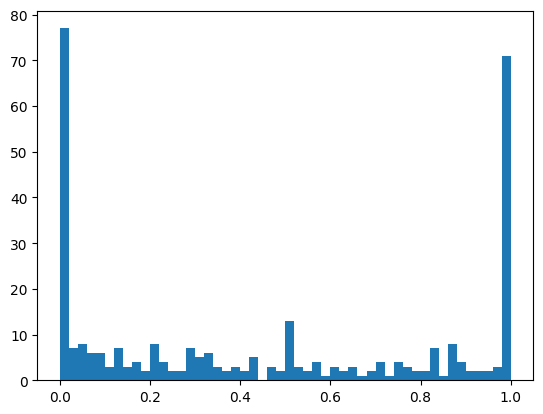

In [27]:
plt.hist(rule_feas['mean_feasibility'], bins=50)
plt.show()

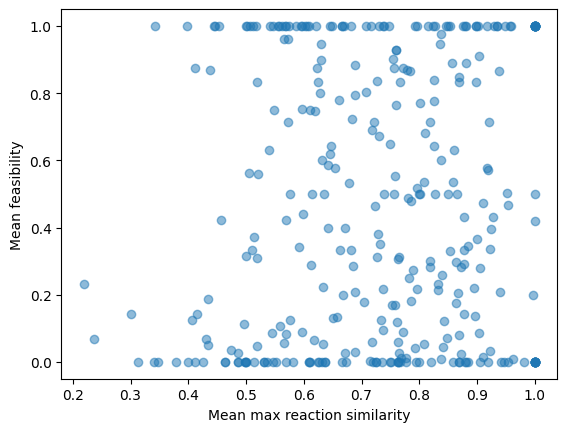

In [32]:
fig, ax = plt.subplots()
ax.scatter(rule_feas['mean_max_rxn_sim'], rule_feas['mean_feasibility'], alpha=0.5)
ax.set_xlabel("Mean max reaction similarity")
ax.set_ylabel("Mean feasibility")
plt.show()

/tmp/ipykernel_380169/3298046175.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


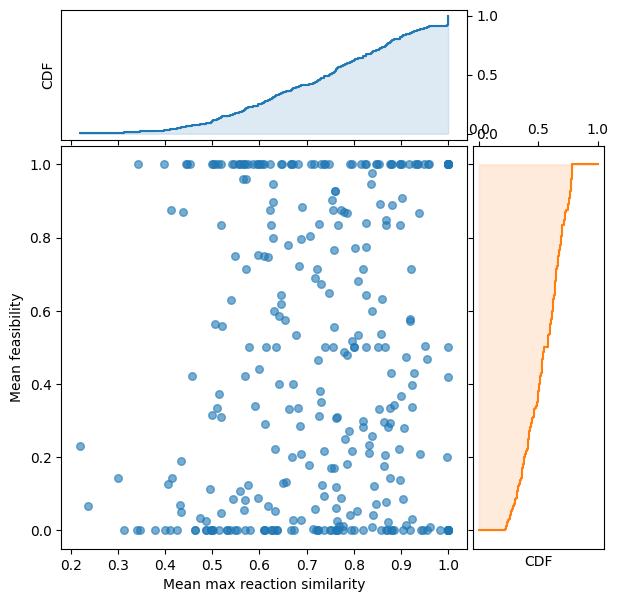

In [33]:
import numpy as np

# prepare data
x = rule_feas["mean_max_rxn_sim"].to_numpy()
y = rule_feas["mean_feasibility"].to_numpy()
n = len(x)

# compute empirical CDFs
sx = np.sort(x)
sy = np.sort(y)
cdf_x = np.arange(1, n + 1) / n
cdf_y = np.arange(1, n + 1) / n

# layout with marginals
fig2 = plt.figure(figsize=(7, 7))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 4, figure=fig2, wspace=0.05, hspace=0.05)

ax_main = fig2.add_subplot(gs[1:, :-1])
ax_top = fig2.add_subplot(gs[0, :-1], sharex=ax_main)
ax_right = fig2.add_subplot(gs[1:, -1], sharey=ax_main)

# main scatter
ax_main.scatter(x, y, alpha=0.6, s=30)
ax_main.set_xlabel("Mean max reaction similarity")
ax_main.set_ylabel("Mean feasibility")

# top marginal: CDF of x
ax_top.step(sx, cdf_x, where="post", color="C0")
ax_top.fill_between(sx, cdf_x, step="post", alpha=0.15, color="C0")
ax_top.set_ylabel("CDF")
plt.setp(ax_top.get_xticklabels(), visible=False)

# right marginal: CDF of y (plot horizontally)
ax_right.step(cdf_y, sy, where="post", color="C1")
ax_right.fill_betweenx(sy, 0, cdf_y, alpha=0.15, color="C1")
ax_right.set_xlabel("CDF")
plt.setp(ax_right.get_yticklabels(), visible=False)

# tidy up limits and ticks
ax_top.set_xlim(ax_main.get_xlim())
ax_right.set_ylim(ax_main.get_ylim())
ax_top.yaxis.tick_right()
ax_right.xaxis.tick_top()

fig2.tight_layout()
plt.show()

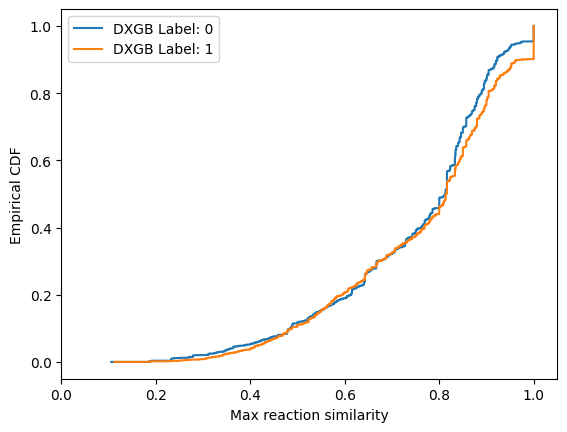

In [37]:
fig, ax = plt.subplots()
for i in [0, 1]:
    _data = rxn_metrics.filter(pl.col("dxgb_label") == i)['max_rxn_sim'].to_numpy()
    ycdf = np.arange(1, len(_data) + 1) / len(_data)
    sx = np.sort(_data)
    ax.step(sx, ycdf, where="post", label=f"DXGB Label: {i}")
ax.set_xlabel("Max reaction similarity")
ax.set_ylabel("Empirical CDF")
ax.set_xlim(0, 1.05)
ax.legend()
plt.show()

In [40]:
krs = pl.read_parquet(
    Path(fps.raw_data) / "known_reactions.parquet"
)
clf = feasibility_classifier(cofactor_positioning='add_concat')
krs.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P30109"", ""P57108"", … ""P46436""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""Q0UK48"", ""A0A0C6E0I7"", … ""A0A0C6DWS6""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""P0DO30"", ""A0A482N9V7""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [ ]:
krs = krs.with_columns(
    pl.col("smarts").map_elements(lambda x: clf.standardize_reaction_smarts(x), return_dtype=pl.String)
)